In [1]:
import matplotlib.pyplot as plt
from distgen import Generator

# create beam
gen = Generator("beams/gaussian.yaml")
gen.run()
gen

C:\ProgramData\Miniconda3\envs\phase_space_reconstruction\lib\site-packages\distgen\generator.py:150: UserWarning: Ignoring user specified t distribution for time start.
  warnings.warn('Ignoring user specified t distribution for time start.')


<disgten.Generator with input: 
n_particle: 1000
output:
  file: rad.gaussian.out.txt
  type: gpt
px_dist:
  sigma_px:
    units: MeV/c
    value: 0.001
  type: gaussian
py_dist:
  sigma_py:
    units: MeV/c
    value: 0.001
  type: gaussian
pz_dist:
  avg_pz:
    units: MeV/c
    value: 1.0
  sigma_pz:
    units: MeV/c
    value: 1.0e-05
  type: gaussian
r_dist:
  sigma_xy:
    units: mm
    value: 10
  type: radial_gaussian
random_type: hammersley
start:
  tstart:
    units: sec
    value: 0
  type: time
t_dist:
  max_t:
    units: ps
    value: 2
  min_t:
    units: ps
    value: -2
  type: uniform
total_charge:
  units: pC
  value: 10

>

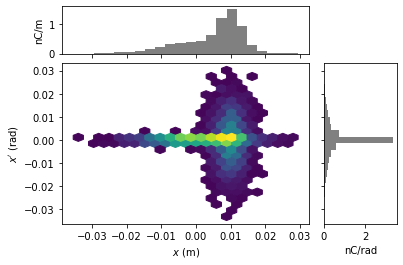

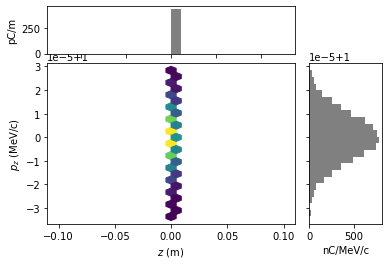

In [2]:
import numpy as np

particles_1 = gen.particles

# add a transformation to gen
setstdx = {'type':'set_std x', 'sigma_x':{'value': 3, 'units': 'mm'}}
setstdpx = {'type':'set_std px', 'sigma_px':{'value': 0.01, 'units': 'MeV/c'}}
transpx = {'type': 'translate x', 'delta': {'value': 0.01, 'units': 'm'}}

#rot2dxxp = {'type':'rotate2d x:xp', 'angle':{'value':45, 'units':'deg'}}

gen.input["transforms"] = {"t1": setstdx, "t2":setstdpx,"t3":transpx, "order":["t1",
                                                                                "t2",
                                                                               "t3"]}
gen.run()
particles_2 = gen.particles

particles = particles_1 + particles_2

particles.plot("x","xp")
particles.plot("z","pz")


In [3]:
particles

<ParticleGroup with 2000 particles at 0x16c49625b10>

In [4]:
# transform particles from distgen to BMAD
from track import Particle
import torch
tkwargs = {"device":"cuda", "dtype": torch.double}

keys = ["x","px","y","py","z","pz"]
defaults = {
        "s": torch.tensor(0.0,**tkwargs),
        "p0c": torch.mean(torch.tensor(particles.pz,**tkwargs)),
        "mc2": torch.tensor(particles.mass,**tkwargs),
    }
print(defaults["p0c"])


ground_truth_in = Particle(
    torch.tensor(particles.x,**tkwargs),
    torch.tensor(particles.xp,**tkwargs),
    torch.tensor(particles.y,**tkwargs),
    torch.tensor(particles.yp,**tkwargs),
    torch.tensor(particles.z,**tkwargs),
    (torch.tensor(particles.pz) - defaults["p0c"]) / defaults["p0c"],
    **defaults
)


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
from normalizing_flow import get_images, image_difference_loss, get_output_beams

# get ground truth images
sizes = []
k_in = torch.linspace(-10,20,10,**tkwargs)
bins = torch.linspace(-50,50,100,**tkwargs)*1e-3
bandwidth = torch.tensor(1e-3,**tkwargs)
ground_truth_output_beams = get_output_beams(ground_truth_in, k_in)
images = get_images(ground_truth_output_beams, bins, bandwidth)

for image in images[:5]:
    fig,ax = plt.subplots()
    xx = torch.meshgrid(bins, bins)
    ax.pcolor(xx[0], xx[1], image)

# test loss
image_difference_loss(ground_truth_in, ground_truth_in, k_in, bins, bandwidth)

In [ ]:
# define a unit multivariate normal
from torch.distributions import MultivariateNormal
normal_samples = MultivariateNormal(torch.zeros(6,**tkwargs), torch.eye(6,**tkwargs)).sample([1000])

# define nonparametric transform
from normalizing_flow import NonparametricTransform, track_in_quad
tnf = NonparametricTransform()

# plot initial beam after transform
p_in_guess = Particle(*tnf(normal_samples).T.double(), **defaults)
plt.hist2d(p_in_guess.x.detach().numpy(), p_in_guess.px.detach().numpy(), bins=50)

plt.figure()
p_out_guess = track_in_quad(p_in_guess, k_in[0])
plt.hist2d(p_out_guess.x.detach().numpy(), p_out_guess.px.detach().numpy(), bins=50);


In [ ]:
# preform optimization with Adam to generate a beam with zero centroid
from normalizing_flow import image_difference_loss, beam_position_loss, zero_centroid_loss

optim = torch.optim.Adam(tnf.parameters(), lr=0.01)
n_iter = 1000
losses = []
image_difference_losses = []
beam_position_losses = []

keys = ["x", "px", "y", "py", "z", "pz"]

for i in range(n_iter):
    optim.zero_grad()

    #transformed_samples = tnf(normal_samples).double()
    guess_dist = Particle(*tnf(normal_samples).T.double(), **defaults)
    #coords = torch.cat([getattr(guess_dist, key).unsqueeze(0) for key in keys], dim=0)
    #loss = torch.sum(coords.mean(dim=0).pow(2)).sqrt()

    loss = image_difference_loss(
        guess_dist,
        ground_truth_in,
        k_in,
        bins=bins,
        bandwidth=bandwidth
    )
    losses += [loss.detach()]
    loss.backward()

    optim.step()

    if i % 100 == 0:
        print(i)

fig, ax = plt.subplots()
ax.semilogy(losses)


In [ ]:
loss = image_difference_loss(
        Particle(*tnf(normal_samples).T.double(), **defaults),
        ground_truth_in,
        k_in,
        bins=bins,
        bandwidth=bandwidth,
        plot_images=True
    )

In [ ]:
# plot initial beam after transform
p_in_guess = Particle(*tnf(normal_samples).T.double(), **defaults)
plt.hist2d(p_in_guess.x.detach().numpy(), p_in_guess.px.detach().numpy(), bins=50)

plt.figure()
p_out_guess = track_in_quad(p_in_guess, k_in[0])
plt.hist2d(p_out_guess.x.detach().numpy(), p_out_guess.y.detach().numpy(), bins=50);